<a href="https://colab.research.google.com/github/jeknov/ML-short-demos/blob/master/ULMFiT_fastai_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 576.2MB 24kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
#import dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [0]:
# create a dataframe
df = pd.DataFrame({'label':dataset.target,
                   'text':dataset.data})

In [0]:
df.shape

(11314, 2)

In [0]:
df.head()

,label,text
0,17,Well i'm not sure about the story nad it did s...
1,0,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,17,Although I realize that principle is not one o...
3,11,Notwithstanding all the legitimate fuss about ...
4,10,"Well, I will have to change the scoring on my ..."


In [0]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

In [0]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

In [0]:
df.head()

,label,text
0,10,"Well, I will have to change the scoring on my ..."
1,1,Archive-name: graphics/resources-list/part1\nL...
2,10,"\nAnd of course, Mike Ramsey was (at one time)..."
3,10,"As I promised, I would give you the name of th..."
4,10,GAME(S) OF 4/15\n---------------\nADIRONDACK 6...


### Preprocessing

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') 

In [0]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc

In [0]:
df.head()

,label,text
0,10,Well I change scoring playoff pool Unfortunate...
1,1,Archive name graphics resources list part Last...
2,10,And course Mike Ramsey one time captain Buffal...
3,10,As I promised I would give name Panther presid...
4,10,GAME S OF ADIRONDACK CDI Adirondack leads seri...


In [0]:
df.text[0]

'Well I change scoring playoff pool Unfortunately I time right I certainly post new scoring rules tomorrow Does matter No enter anyway Good Keith Keller LET S GO RANGERS LET S GO QUAKERS kkeller mail sas upenn edu IVY LEAGUE CHAMPS'

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [0]:
df_trn.shape, df_val.shape

((710, 2), (474, 2))

### Data Preparation

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_lm

TextLMDataBunch;

Train: LabelList (710 items)
x: LMTextList
xxbos xxmaj it looks like xxmaj edmonton xxmaj oilers decided take xxmaj european xxunk spring xxmaj ranford xxmaj tugnutt xxmaj benning xxmaj manson xxmaj smith xxmaj buchberger xxmaj corson playing xxmaj canada xxmaj podein xxmaj weight playing xxup us xxmaj is xxmaj kravchuk playing xxmaj xxunk i know nagging injuries late season xxmaj podein interesting case eligible play xxmaj cape xxmaj breton xxup ahl playoffs like xxmaj kovalev xxmaj zubov xxmaj andersson obviously xxmaj sather xxmaj pocklington total xxunk everyone makes certainly case massively xxunk xxmaj paramount xxmaj new xxmaj york xxmaj rangers,xxbos xxmaj this xxunk xxmaj speaking die hard i i read xxunk hard xxunk xxmaj toronto xxmaj cup finals xxmaj first anyone planet heard team xxmaj detroit xxmaj al xxmaj xxunk however spell idiot name must xxmaj chicago xxup espn said even close xxmaj chicago xxunk win xxmaj norris xxmaj division xxmaj playoffs team clo

In [0]:
data_clas

TextClasDataBunch;

Train: LabelList (710 items)
x: TextList
xxbos xxmaj it looks like xxmaj edmonton xxmaj oilers decided take xxmaj european xxunk spring xxmaj ranford xxmaj tugnutt xxmaj benning xxmaj manson xxmaj smith xxmaj buchberger xxmaj corson playing xxmaj canada xxmaj podein xxmaj weight playing xxup us xxmaj is xxmaj kravchuk playing xxmaj xxunk i know nagging injuries late season xxmaj podein interesting case eligible play xxmaj cape xxmaj breton xxup ahl playoffs like xxmaj kovalev xxmaj zubov xxmaj andersson obviously xxmaj sather xxmaj pocklington total xxunk everyone makes certainly case massively xxunk xxmaj paramount xxmaj new xxmaj york xxmaj rangers,xxbos xxmaj this xxunk xxmaj speaking die hard i i read xxunk hard xxunk xxmaj toronto xxmaj cup finals xxmaj first anyone planet heard team xxmaj detroit xxmaj al xxmaj xxunk however spell idiot name must xxmaj chicago xxup espn said even close xxmaj chicago xxunk win xxmaj norris xxmaj division xxmaj playoffs team clo

In [0]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [0]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.659338,5.537808,0.231394,00:04


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


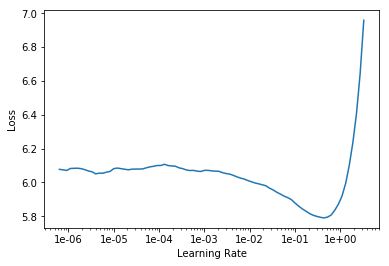

In [0]:
learn.recorder.plot()

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


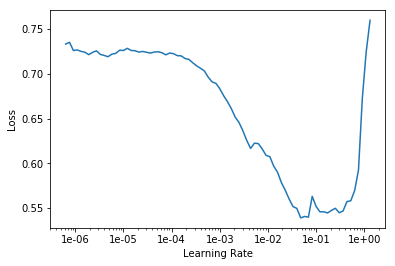

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.443795,0.280205,0.934599,00:14
